# Volatility Smile Trading Strategies

This notebook explores a **volatility smile trading strategy** designed to capitalize on **anomalies in the implied volatility (IV) curve**, also known as the **volatility skew** or **smile**. 

In options markets, implied volatility is not constant across strikes — options with different strike prices (but the same expiration) often have **different IVs**. This results in a curved or sloped structure when plotting IV versus strike, known as the **volatility smile** (for symmetric shapes) or **volatility skew** (for asymmetric slopes).

These skews reflect market forces such as:
- Demand for downside protection (steep put skew in equities)
- Supply/demand imbalances
- Event pricing (earnings, Fed announcements)
- Perceived tail risks

Skew trading aims to **exploit deviations** in this curve, particularly when:
- A specific strike’s IV appears **misaligned** with surrounding strikes
- The overall skew becomes **unusually steep or flat**
- The skew deviates from its historical norm

In [3]:
from mibian import BS
import pandas as pd
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')

## Fetching Options Data
We fetch data from a CSV file that contains call option data for a week of NIFTY50 call options expiring on Dec 28, 2017. We store this data in the dataframe nifty_data. Next, we define a new column in the dataframe with the header 'IV' and initialize it to 0. The implied volatilities will be stored under this header.


In [4]:
nifty_data = pd.read_csv('data_modules/Option_data_NIFTY.csv')
nifty_data

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value,Time to Expiry
0,NIFTY,10-11-2017,28-Dec-17,CE,10100,342.00,384.55,319.95,346.65,357.25,346.65,369,2891.94,96.77,270000,6000,10321.75,48
1,NIFTY,10-11-2017,28-Dec-17,CE,10200,274.05,308.15,246.00,280.10,288.00,280.10,814,6395.29,168.19,463125,1200,10321.75,48
2,NIFTY,10-11-2017,28-Dec-17,CE,10300,213.15,239.05,184.95,214.45,220.00,214.45,2489,19614.17,386.64,583650,7725,10321.75,48
3,NIFTY,10-11-2017,28-Dec-17,CE,10400,156.10,177.75,133.40,153.65,161.45,153.65,2648,20963.42,309.02,436650,3675,10321.75,48
4,NIFTY,10-11-2017,28-Dec-17,CE,10500,117.45,128.45,92.60,112.20,117.70,112.20,8500,67640.94,703.44,1862175,2625,10321.75,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,NIFTY,20-11-2017,28-Dec-17,CE,11300,0.00,0.00,0.00,3.25,3.25,1.20,0,0.00,0.00,300,0,10298.75,38
115,NIFTY,20-11-2017,28-Dec-17,CE,11400,4.50,4.50,4.40,4.50,4.50,4.50,13,111.19,0.04,367275,75,10298.75,38
116,NIFTY,20-11-2017,28-Dec-17,CE,11500,2.15,3.05,2.15,2.95,3.00,2.95,205,1768.56,0.43,181950,-2700,10298.75,38
117,NIFTY,20-11-2017,28-Dec-17,CE,11600,0.00,0.00,0.00,19.60,0.00,0.15,0,0.00,0.00,0,0,10298.75,38


## Computing implied volatilities

In [5]:
nifty_data['IV'] = 0

for row in range(0,len(nifty_data)):       
    underlyingPrice = nifty_data.iloc[row]['Underlying Value']
    strikePrice = nifty_data.iloc[row]['Strike Price']
    interestRate = 0
    daysToExpiration = nifty_data.iloc[row]['Time to Expiry']
    
    callPrice = nifty_data.iloc[row]['LTP']
    
    result = BS([underlyingPrice, strikePrice, interestRate, daysToExpiration],
                callPrice = callPrice)
    
    nifty_data.iloc[row,nifty_data.columns.get_loc('IV')] = result.impliedVolatility

nifty_data['IV']

0      15.541077
1      14.945984
2      14.007568
3      13.218880
4      12.878418
         ...    
114    13.801575
115    15.625000
116    15.808105
117          NaN
118          NaN
Name: IV, Length: 119, dtype: float64

## Defining plot_smile function
Here, we will be defining a function to plot the smile for a particular date of the dataset by taking the value of the row index as its inputs. This function will be called later to plot the volatility smiles when we identify a bump or an anomaly. 


In [6]:
def plot_smile(row):
    option_data = nifty_data[nifty_data['Date'] == nifty_data.iloc[row]['Date']]
    plt.plot(option_data['Strike Price'], option_data['IV'])
    plt.legend(option_data['Date'])
    plt.ylabel('Implied Volatility')
    plt.xlabel('Strike Price')           
    #plt.show()

## Strategy: Localized kinks

The strategy implemented here identifies **localized bumps or kinks** in the IV curve that are **likely to mean-revert**. By entering structured option spreads (such as **short butterflies**, **risk reversals**, or **vertical spreads**), we aim to profit from the normalization of skew.

This approach is **directionally neutral** and focuses on the **relative pricing of volatility across strikes**, rather than predicting the underlying asset's movement.

Position opened
 Date: 13-11-2017
 Strike: 11400
 Money Received: INR 6.499999999999999


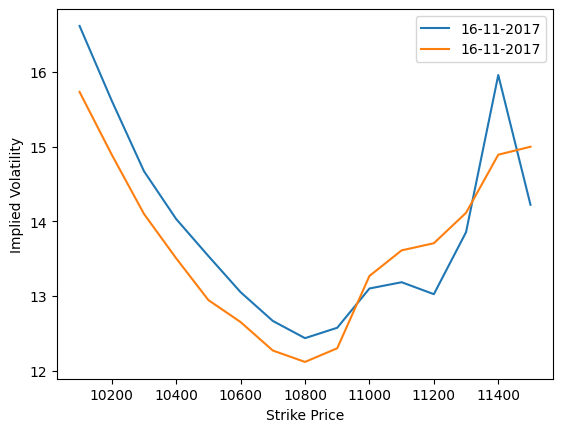

Position closed
 Date: 16-11-2017
 Strike: 11400
 Money Paid: INR 0.6999999999999997


In [ ]:
# TODO: Add time limit for the trade
# TODO: Add Drawodwn plot along the P&L
# TODO: Try different vol_bump values

nifty_data["Signal"] = 0
nifty_data["PNL"] = 0
nifty_data["MTM"] = 0

sig_i   = nifty_data.columns.get_loc('Signal')
pnl_i   = nifty_data.columns.get_loc('PNL')
mtm_i   = nifty_data.columns.get_loc('MTM')
uv_i    = nifty_data.columns.get_loc('Underlying Value')
sp_i    = nifty_data.columns.get_loc('Strike Price')
iv_i    = nifty_data.columns.get_loc('IV')
ltp_i   = nifty_data.columns.get_loc('LTP')
date_i  = nifty_data.columns.get_loc('Date')

total_rows   = len(nifty_data)
vol_bump     = 1.5       # Size of the volaility bump
open_position_i = None  # will hold the row index of the open butterfly, or None

for row in range(1, total_rows - 1):
    # --- Date checks for neighbors ---
    today     = nifty_data.iat[row, date_i]
    prev_date = nifty_data.iat[row-1, date_i]
    next_date = nifty_data.iat[row+1, date_i]
    same_prev = (today == prev_date)
    same_next = (today == next_date)

    # --- Carry forward existing Signal ---
    if open_position_i is not None:
        nifty_data.iat[row, sig_i] = 1
    else:
        nifty_data.iat[row, sig_i] = 0

    # --- OPENING LOGIC: only when no position is open ---
    if nifty_data.iat[row, sig_i] == 0:
        ITM = (nifty_data.iat[row, uv_i] > nifty_data.iat[row, sp_i])
        OTM = (nifty_data.iat[row, uv_i] < nifty_data.iat[row, sp_i])

        # Require both neighbors on same date so K−1, K, K+1 all valid
        if ITM and same_prev and same_next:
            # bump relative to the lower strike
            if nifty_data.iat[row, iv_i] > (nifty_data.iat[row-1, iv_i] + vol_bump):
                # **OPEN** butterfly position
                nifty_data.iat[row, sig_i] = 1
                pnl = (
                    2 * nifty_data.iat[row, ltp_i]   # Sell 2 Call options at K
                    - nifty_data.iat[row-1, ltp_i]  # Buy 1 Call option at K - 1
                    - nifty_data.iat[row+1, ltp_i] # Buy 1 Call option at K+1
                )
                nifty_data.iat[row, pnl_i] = pnl
                open_position_i = row
                plot_smile(row)
                label = "Money Received" if pnl > 0 else "Money Paid"
                print(
                    "Position opened\n"
                    f" Date: {today}\n"
                    f" Strike: {nifty_data.iat[row, sp_i]}\n"
                    f" {label}: INR {abs(pnl)}"
                )

        elif OTM and same_prev and same_next:
            # bump relative to the higher strike
            if nifty_data.iat[row, iv_i] > (nifty_data.iat[row+1, iv_i] + vol_bump):
                # **OPEN** butterfly
                nifty_data.iat[row, sig_i] = 1
                pnl = (
                    2 * nifty_data.iat[row, ltp_i]
                    - nifty_data.iat[row-1, ltp_i]
                    - nifty_data.iat[row+1, ltp_i]
                )
                nifty_data.iat[row, pnl_i] = pnl
                open_position_i = row
                plot_smile(row)
                label = "Money Received" if pnl > 0 else "Money Paid"
                print(
                    "Position opened\n"
                    f" Date: {today}\n"
                    f" Strike: {nifty_data.iat[row, sp_i]}\n"
                    f" {label}: INR {abs(pnl)}"
                )

    # --- CLOSING LOGIC: when we have an open position at the same strike ---
    elif open_position_i is not None and nifty_data.iat[row, sp_i] == nifty_data.iat[open_position_i, sp_i]:
        ITM = nifty_data.iat[row, uv_i] > nifty_data.iat[row, sp_i]
        OTM = nifty_data.iat[row, uv_i] < nifty_data.iat[row, sp_i]

        # Only close if neighbors still on same date
        if same_prev and same_next:
            if ITM:
                # bump has reverted vs. lower strike
                if nifty_data.iat[row, iv_i] < nifty_data.iat[row-1, iv_i]:
                    nifty_data.iat[row, sig_i] = 0
                    pnl = -(
                        2 * nifty_data.iat[row, ltp_i]
                        - nifty_data.iat[row-1, ltp_i]
                        - nifty_data.iat[row+1, ltp_i]
                    )
                    nifty_data.iat[row, pnl_i] = pnl
                    open_position_i = None
                    plot_smile(row)
                    label = "Money Received" if pnl > 0 else "Money Paid"
                    print(
                        "Position closed\n"
                        f" Date: {today}\n"
                        f" Strike: {nifty_data.iat[row, sp_i]}\n"
                        f" {label}: INR {abs(pnl)}"
                    )

            elif OTM:
                # bump has reverted vs. higher strike
                if nifty_data.iat[row, iv_i] < nifty_data.iat[row+1, iv_i]:
                    nifty_data.iat[row, sig_i] = 0
                    pnl = -(
                        2 * nifty_data.iat[row, ltp_i]
                        - nifty_data.iat[row-1, ltp_i]
                        - nifty_data.iat[row+1, ltp_i]
                    )
                    nifty_data.iat[row, pnl_i] = pnl
                    open_position_i = None
                    plot_smile(row)
                    plt.show()
                    label = "Money Received" if pnl > 0 else "Money Paid"
                    print(
                        "Position closed\n"
                        f" Date: {today}\n"
                        f" Strike: {nifty_data.iat[row, sp_i]}\n"
                        f" {label}: INR {abs(pnl)}"
                    )

        # MTM update even if not closing
        nifty_data.iat[row, mtm_i] = (
            2 * nifty_data.iat[row, ltp_i]
            - nifty_data.iat[row-1, ltp_i]
            - nifty_data.iat[row+1, ltp_i]
        )

### Computing cumulative P&L

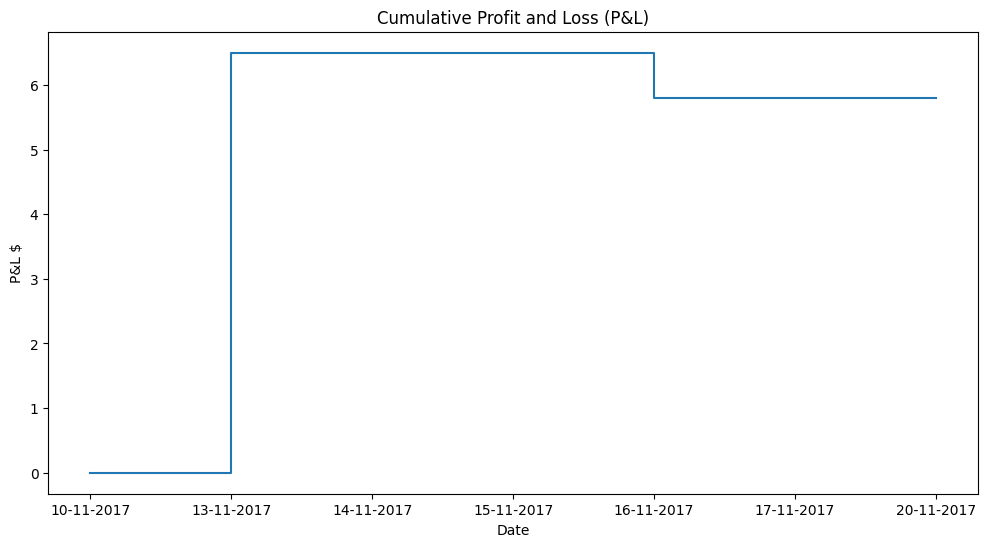



Cumulative PNL from volatility smile trading strategy: INR 5.8


In [8]:
nifty_data['Cumulative PNL'] = nifty_data.PNL.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(nifty_data["Date"], nifty_data["Cumulative PNL"])
plt.title("Cumulative Profit and Loss (P&L)")
plt.xlabel("Date")
plt.ylabel("P&L $")
plt.show()

print("\n\nCumulative PNL from volatility smile trading strategy: INR", nifty_data['Cumulative PNL'].iloc[-1].round(2))

Volatility skews comes from the fatc that OTM Put worht more than OTM Call becasue investors have a bearish sentimetn about the underlying price, thus the demand for OTM Put rises. Thus the skew can help indicate teh direction of the market. All of that because the IV are diretcly proportional to the prices, amrket sentiment can be gauged throuygh an undertadning of the level of IV.

The most basic and common measure of skew is the first derivative (slope) of implied volatility with respect to strike:

Their are many formulas for the skew, but here we are going to use the followign one:
$$Skew  =

$$